# Model 2 - Count Vectorization / Extra Trees

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree

pd.set_option('display.max_colwidth', None)

In [2]:
plants = pd.read_csv('../data/data_cleaned/plants.csv')

In [3]:
plants.head()

,id,created_utc,title,self_text,comments,score,upvote_ratio,subreddit
0,uw3f46,1.653321e+09,I feel attacked.,no_text,793,63651,0.94,1
1,v4z9xu,1.654380e+09,The liberals are trying to make my plants gay!!,no_text,1281,54217,0.82,1
2,q0hqvn,1.633268e+09,This was supposed to be a plant progress post showing off my oxalis but Henk stole the show,no_text,572,45198,0.96,1
3,i5rplr,1.596855e+09,My grandpa made me a plant stand 💖,no_text,451,40218,0.96,1
4,lkjvss,1.613414e+09,I let my Golden Pothos get outta hand for just this reason. It’s like a little jungle for him.,no_text,593,39723,0.98,1


In [4]:
plants.shape

(9271, 8)

In [5]:
X = plants['title']
y = plants['subreddit']

In [6]:
X.shape

(9271,)

### Train, Test, Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

In [8]:
X_train.shape

(6953,)

### Benchmark Model

In [9]:
pipe_bench = Pipeline([
    ('cvec_bench', CountVectorizer()),
    ('et_bench', ExtraTreesClassifier(random_state=21))
])

In [10]:
pipe_bench.fit(X_train, y_train)

Pipeline(steps=[('cvec_bench', CountVectorizer()),
                ('et_bench', ExtraTreesClassifier(random_state=21))])

In [11]:
pipe_bench.score(X_train, y_train)

0.9953976700704732

In [12]:
pipe_bench.score(X_test, y_test)

0.8390854184641933

In [13]:
1 - y.mean()

0.4891597454427785

In [14]:
pipe_bench.get_params()

{'memory': None,
 'steps': [('cvec_bench', CountVectorizer()),
  ('et_bench', ExtraTreesClassifier(random_state=21))],
 'verbose': False,
 'cvec_bench': CountVectorizer(),
 'et_bench': ExtraTreesClassifier(random_state=21),
 'cvec_bench__analyzer': 'word',
 'cvec_bench__binary': False,
 'cvec_bench__decode_error': 'strict',
 'cvec_bench__dtype': numpy.int64,
 'cvec_bench__encoding': 'utf-8',
 'cvec_bench__input': 'content',
 'cvec_bench__lowercase': True,
 'cvec_bench__max_df': 1.0,
 'cvec_bench__max_features': None,
 'cvec_bench__min_df': 1,
 'cvec_bench__ngram_range': (1, 1),
 'cvec_bench__preprocessor': None,
 'cvec_bench__stop_words': None,
 'cvec_bench__strip_accents': None,
 'cvec_bench__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec_bench__tokenizer': None,
 'cvec_bench__vocabulary': None,
 'et_bench__bootstrap': False,
 'et_bench__ccp_alpha': 0.0,
 'et_bench__class_weight': None,
 'et_bench__criterion': 'gini',
 'et_bench__max_depth': None,
 'et_bench__max_features': 'sqrt',
 'et_

### Production Model

In [15]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('et', ExtraTreesClassifier(random_state=21))
])

In [16]:
pipe_params = {
    'cvec__max_features': [None],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [.9, 1.0],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': [None, 'english'],
    'et__n_estimators': [100, 500],
    'et__max_features': ['sqrt'],
    'et__max_depth': [None],
    'et__min_samples_leaf': [1]
}

In [17]:
gs = GridSearchCV(pipe,
                  param_grid = pipe_params,
                  cv = 5,
                  n_jobs=8
)

In [18]:
%%time
gs.fit(X_train, y_train)

CPU times: user 1min 37s, sys: 6.66 s, total: 1min 44s
Wall time: 19min 30s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('et',
                                        ExtraTreesClassifier(random_state=21))]),
             n_jobs=8,
             param_grid={'cvec__max_df': [0.9, 1.0],
                         'cvec__max_features': [None],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'et__max_depth': [None], 'et__max_features': ['sqrt'],
                         'et__min_samples_leaf': [1],
                         'et__n_estimators': [100, 500]})

In [19]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'et__max_depth': None,
 'et__max_features': 'sqrt',
 'et__min_samples_leaf': 1,
 'et__n_estimators': 500}

### Scores

In [20]:
gs.score(X_train, y_train)

0.9955414928807709

In [21]:
gs.score(X_test, y_test)

0.8451251078515962

### Predictions

In [22]:
preds = gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

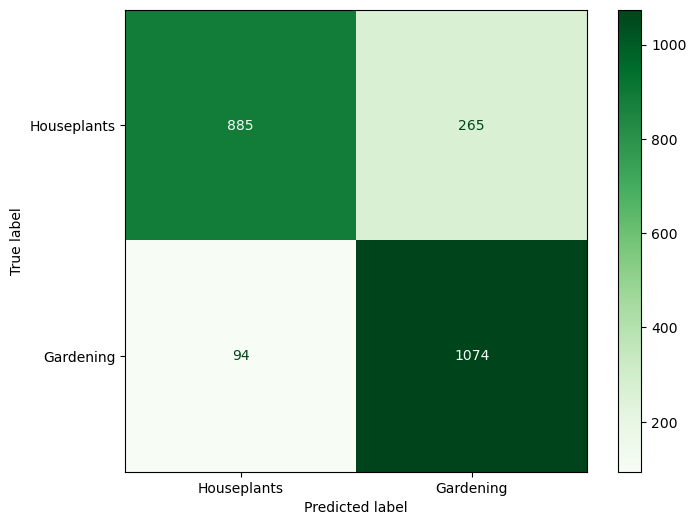

In [57]:
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Greens', ax=ax, display_labels=['Houseplants', 'Gardening']);

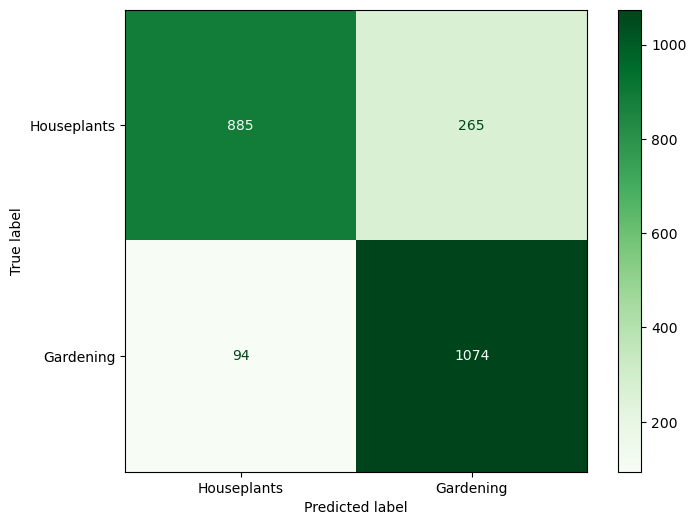

In [58]:
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap='Greens', ax=ax, display_labels=['Houseplants', 'Gardening'])
plt.savefig('../images/model_2_confusion', dpi=300); 

In [25]:
print(classification_report(y_test, preds, digits = 5))

              precision    recall  f1-score   support

           0    0.90398   0.76957   0.83138      1150
           1    0.80209   0.91952   0.85680      1168

    accuracy                        0.84513      2318
   macro avg    0.85304   0.84454   0.84409      2318
weighted avg    0.85264   0.84513   0.84419      2318



In [26]:
misclassified_indices = (preds != y_test)

In [27]:
misclassified_indices

5799    False
3599    False
4819    False
966     False
448     False
        ...  
4215    False
4852     True
4618    False
1474    False
6695     True
Name: subreddit, Length: 2318, dtype: bool

In [28]:
misclassified_df = pd.DataFrame({
    'Misclassified_Posts': X_test[misclassified_indices],
    'True Labels': y_test[misclassified_indices],
    'Predicted_Labels': preds[misclassified_indices]
})

In [29]:
misclassified_df.head(50)

,Misclassified_Posts,True Labels,Predicted_Labels
4847,Update on my Ohio pineapple,0,1
6600,so proud of my babies...,0,1
8203,Chunky potting mix,0,1
5622,ain’t stupid if it works,0,1
5202,Before and after. Really proud.,0,1
6682,"I just started to learn to prune, how is it ? Any thoughts on improvements?",0,1
5713,Social distancing in my safe room.,0,1
8511,What plant is this and how do I overwinter it in Nebraska?,0,1
5385,"Oh well, one day maybe",0,1
6135,"My preschooler came home with a milk carton filled with dirt. Per her words “we gotta give it suns, waters and winds.” So, we did that. Now what?",0,1


In [51]:
misclassified_df.sample(n=50)

,Misclassified_Posts,True Labels,Predicted_Labels
7402,tfw the plant u highkey neglected is doing much better than the divas u regularly tend to,0,1
4902,Succulent rainbow after a storm!,0,1
3605,Looking for advice on terracotta watering bulbs and majesty palms!,1,0
5070,My peace of heaven,0,1
4942,My zebra’s butthole finally bloomed!!,0,1
8173,Plant identification,0,1
8557,Giant pink Mandevilla dying?,0,1
4168,Help,1,0
6989,What are these?,0,1
8317,Too late to plant boysenberry’s ?,0,1


### Feature Importance

In [30]:
feature_importances = gs.best_estimator_.named_steps['et'].feature_importances_

In [31]:
importance_df = pd.DataFrame({
    'feature': gs.best_estimator_.named_steps['cvec'].get_feature_names_out(),
    'importance': feature_importances
})

In [43]:
importance_df = importance_df.sort_values(by='importance', ascending=False).head(15)

In [44]:
importance_df

,feature,importance
11123,garden,0.018534
12987,harvest,0.011503
19060,monstera,0.010659
19901,my garden,0.007276
23841,plant,0.006773
32820,tomato,0.005200
11285,gardening,0.005043
32848,tomatoes,0.004558
27075,seeds,0.004506
24195,plants,0.004195


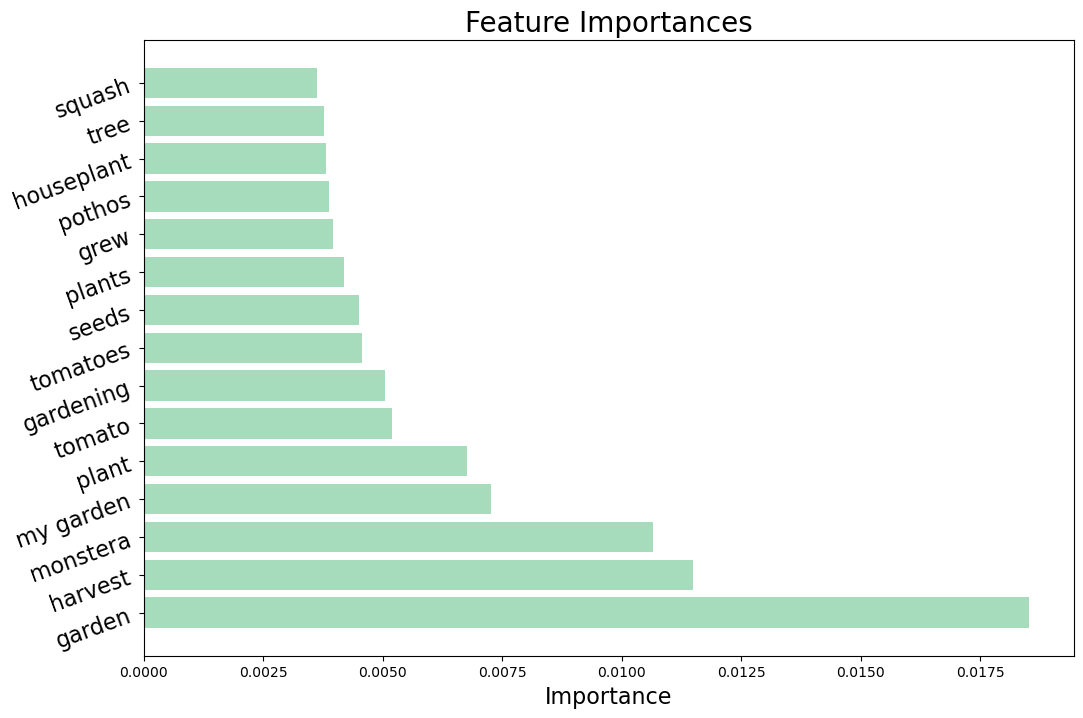

In [50]:
plt.figure(figsize=(12, 8))
plt.barh(importance_df['feature'], importance_df['importance'], color='#a6dbbc')
plt.xlabel('Importance', fontsize=16)
plt.yticks(rotation=20, fontsize=16)
plt.title('Feature Importances', fontsize=20)
plt.savefig('../images/model_2_feature_importance', dpi=300);